   # Wide and Deep Learning Regression
   Based on Googles tutorial at: https://www.tensorflow.org/tutorials/wide_and_deep
   Licensed under Apache 2.0 open source. 
   http://www.apache.org/licenses/LICENSE-2.0
   
   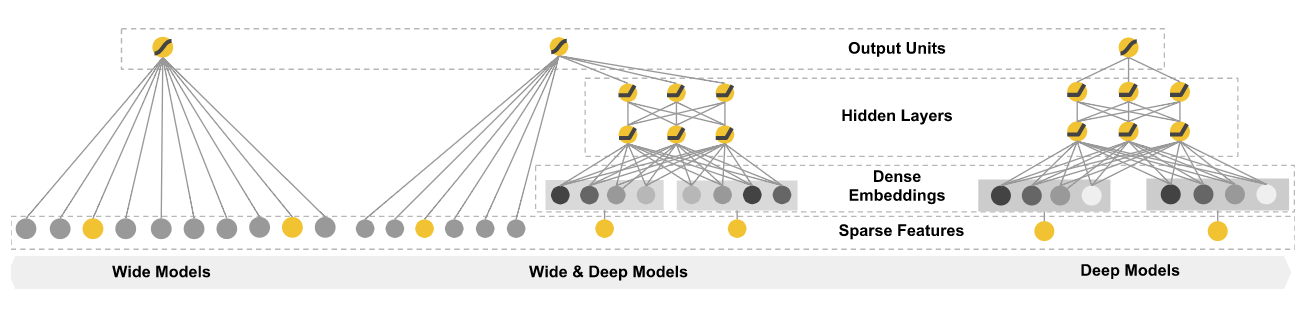

## Define Base Feature Columns
First, let's define the base categorical and continuous feature columns that we'll use. These base columns will be the building blocks used by both the wide part and the deep part of the model.

In [1]:
import tensorflow as tf

In [2]:
# Continuous columns
age = tf.feature_column.numeric_column('age')
education_num = tf.feature_column.numeric_column('education_num')
capital_gain = tf.feature_column.numeric_column('capital_gain')
capital_loss = tf.feature_column.numeric_column('capital_loss')
hours_per_week = tf.feature_column.numeric_column('hours_per_week')

education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education', [
        'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
        '5th-6th', '10th', '1st-4th', 'Preschool', '12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital_status', [
        'Married-civ-spouse', 'Divorced', 'Married-spouse-absent',
        'Never-married', 'Separated', 'Married-AF-spouse', 'Widowed'])

relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    'relationship', [
        'Husband', 'Not-in-family', 'Wife', 'Own-child', 'Unmarried',
        'Other-relative'])

workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass', [
        'Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov',
        'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'])

# To show an example of hashing:
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    'occupation', hash_bucket_size=1000)

# Transformations.
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

## The Wide Model: Linear Model with Crossed Feature Columns
The wide model is a linear model with a wide set of sparse and crossed feature columns:

In [3]:
base_columns = [
    education, marital_status, relationship, workclass, occupation,
    age_buckets,
]

crossed_columns = [
    tf.feature_column.crossed_column(
        ['education', 'occupation'], hash_bucket_size=1000),
    tf.feature_column.crossed_column(
        [age_buckets, 'education', 'occupation'], hash_bucket_size=1000),
]

In [4]:
deep_columns = [
    age,
    education_num,
    capital_gain,
    capital_loss,
    hours_per_week,
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(marital_status),
    tf.feature_column.indicator_column(relationship),
    # To show an example of embedding
    tf.feature_column.embedding_column(occupation, dimension=8),
]

In [13]:
class _ : # this is an empty shell class
    pass

FLAGS = _
FLAGS.model_dir = "."
FLAGS.model_type = "wide_deep"
FLAGS.train_epochs = 10
FLAGS.epochs_per_eval = 2
FLAGS.batch_size = 40
FLAGS.train_data = "./adult.data"
FLAGS.test_data = "./adult.test"
FLAGS._SHUFFLE_BUFFER = 10

_CSV_COLUMN_DEFAULTS = [[0], [''], [0], [''], [0], [''], [''], [''], [''], [''],
                        [0], [0], [0], [''], ['']]

_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

In [14]:
def input_fn(data_file, num_epochs, shuffle, batch_size):
  """Generate an input function for the Estimator."""
  assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have either run data_download.py or '
      'set both arguments --train_data and --test_data.' % data_file)

  def parse_csv(value):
    print('Parsing', data_file)
    columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
    features = dict(zip(_CSV_COLUMNS, columns))
    labels = features.pop('income_bracket')
    return features, tf.equal(labels, '>50K')

  # Extract lines from input files using the Dataset API.
  dataset = tf.data.TextLineDataset(data_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=FLAGS._SHUFFLE_BUFFER)

  dataset = dataset.map(parse_csv, num_parallel_calls=5)

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = dataset.repeat(num_epochs)
  dataset = dataset.batch(batch_size)

  iterator = dataset.make_one_shot_iterator()
  features, labels = iterator.get_next()
  return features, labels

In [15]:
model = tf.estimator.DNNLinearCombinedClassifier(
    model_dir='./census_model',
    linear_feature_columns=base_columns + crossed_columns,
    dnn_feature_columns=deep_columns,
    dnn_hidden_units=[100, 50])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_service': None, '_session_config': None, '_model_dir': './census_model', '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_tf_random_seed': None, '_task_type': 'worker', '_is_chief': True, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A3E942CC18>, '_master': '', '_save_checkpoints_steps': None, '_task_id': 0, '_log_step_count_steps': 100}


In [16]:
# Train and evaluate the model every `FLAGS.epochs_per_eval` epochs.
for n in range(FLAGS.train_epochs // FLAGS.epochs_per_eval):
  model.train(input_fn=lambda: input_fn(
      FLAGS.train_data, FLAGS.epochs_per_eval, True, FLAGS.batch_size))

  results = model.evaluate(input_fn=lambda: input_fn(
      FLAGS.test_data, 1, False, FLAGS.batch_size))

  # Display evaluation metrics
  print('Results at epoch', (n + 1) * FLAGS.epochs_per_eval)
  print('-' * 30)

  for key in sorted(results):
    print('%s: %s' % (key, results[key]))

Parsing ./adult.data
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./census_model\model.ckpt-11406
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11407 into ./census_model\model.ckpt.
INFO:tensorflow:step = 11407, loss = 15.696762
INFO:tensorflow:global_step/sec: 97.4665
INFO:tensorflow:step = 11507, loss = 11.163063 (1.015 sec)
INFO:tensorflow:global_step/sec: 227.708
INFO:tensorflow:step = 11607, loss = 15.764944 (0.442 sec)
INFO:tensorflow:global_step/sec: 203.915
INFO:tensorflow:step = 11707, loss = 12.10465 (0.487 sec)
INFO:tensorflow:global_step/sec: 272.472
INFO:tensorflow:step = 11807, loss = 14.843469 (0.366 sec)
INFO:tensorflow:global_step/sec: 251.457
INFO:tensorflow:step = 11907, loss = 12.825766 (0.405 sec)
INFO:tensorflow:global_step/sec: 288.192
INFO

INFO:tensorflow:global_step/sec: 299.347
INFO:tensorflow:step = 16265, loss = 16.962486 (0.327 sec)
INFO:tensorflow:Saving checkpoints for 16293 into ./census_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.10433762.
Parsing ./adult.test
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-02-06:15:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./census_model\model.ckpt-16293
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-02-06:15:18
INFO:tensorflow:Saving dict for global step 16293: accuracy = 0.8520361, accuracy_baseline = 0.76377374, auc = 0.9011748, auc_precision_recall = 0.7665468, average_loss = 0.32544422, global_step = 16293, label/mean = 0.23622628, loss = 12.98666, prediction/mean = 0.24294214
Results at epoch 6
------------------------------
accuracy: 0.8520361
accuracy_baseline: 0.76